In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import thread_the_needle as ttn


from vi_ppo.actor_critic import ActorCritic
from vi_ppo.nets.mlp import Mlp
from vi_ppo.nets.cnn import Cnn
from vi_ppo.modules import ThreadTheNeedleModule
from vi_ppo.vae import Vae
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
# Initialise the environment
env = ttn.make("thread_the_needle")

# make the actor critic model
d = env.observation_space.shape
n_a = env.action_space.n
hidden_dims = 16


print("Observation space: ", d) 
print("Action space: ", n_a)

Observation space:  (1, 64, 64)
Action space:  4


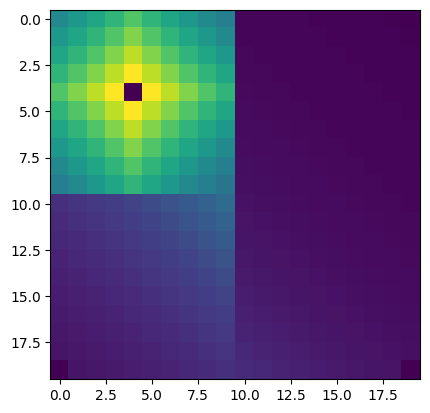

In [3]:
plt.imshow(env.state_values[:-1].reshape(20,20))

In [4]:
env.reset()
env.step(0)

(array([[[ 2,  2,  2, ...,  0,  0,  0],
         [ 2,  2,  2, ...,  0,  0,  0],
         [ 2,  2,  3, ...,  0,  0,  0],
         ...,
         [24, 26, 28, ...,  3,  3,  3],
         [22, 24, 25, ...,  3,  3,  2],
         [21, 22, 23, ...,  3,  3,  2]]], shape=(1, 64, 64)),
 -0.1,
 False,
 False,
 {'start_state': 285,
  'successor_state': 265,
  'state_values': 0.5159661069298376})

In [5]:
# Use a CNN to extract features from the image
feature_extractor_config = Cnn.config_cls(
    input_channels=1, 
    channels=[8,16,1], 
    kernel_sizes=[8,4,1], 
    strides=[2,2,1], 
    padding=[0,0,0],
    flatten_output=True,
    activation="silu",
    )
feature_extractor = Cnn(feature_extractor_config)
embedding_dims = feature_extractor.calculate_output_shape(input_shape=(1,64,64))[1]
print(f"Number of embeddind dimensions: {embedding_dims}")

# Construct the state inference model
z_dim = 2
encoder_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=z_dim * 2, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )
decoder_config = Mlp.config_cls(
    input_dims=z_dim, 
    output_dims=embedding_dims, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )

vae_config  = Vae.config_cls(
    z_dim=z_dim, 
    sigma=1e-4, 
    beta=1.,
    )
vae = Vae(
    vae_config,
    encoder=Mlp(encoder_config), 
    decoder=Mlp(decoder_config)
    )

action_embeddings = nn.Embedding(n_a, z_dim)

transition_network = Mlp(
    Mlp.config_cls(
        input_dims=embedding_dims * 2, 
        output_dims=embedding_dims, 
        hidden_dims=embedding_dims, 
        n_layers=1
    )
)


actor_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=n_a, 
    hidden_dims=hidden_dims,
    n_layers=1, 
)
critic_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=1, 
    hidden_dims=hidden_dims, 
    n_layers=1, 
)
ac_config = ActorCritic.config_cls(
    clip_epsilon=0.2, 
    value_coeff=0.5, 
    entropy_coeff=0.01
)

model = ActorCritic(
    ac_config, 
    actor_net=Mlp(actor_config), 
    critic=Mlp(critic_config), 
    feature_extractor=feature_extractor,
    state_vae = vae,
    action_embeddings=action_embeddings,
    transition_network=transition_network,
    )


# module

Number of embeddind dimensions: 169


In [6]:

config = ThreadTheNeedleModule.config_class(lr=3e-4)
module = ThreadTheNeedleModule(actor_critic=model, env=env, config=config)

logger = TensorBoardLogger("../lightning_logs", name="thread_the_needle/notebook")
trainer = pl.Trainer(max_epochs=20, logger=logger)

trainer.fit(module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nicholasfranklin/miniconda3/envs/vi_ppo/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | actor_critic | ActorCritic | 153 K  | train
-----------------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.613     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode
/Users/nicholasfranklin/miniconda3/envs/vi_ppo/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument`

Training: |          | 0/? [00:00<?, ?it/s]

/Users/nicholasfranklin/Projects/vi_ppo/src/vi_ppo/modules.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).to(self.device)


AttributeError: 'Mlp' object has no attribute 'loss'

In [ ]:
from vi_ppo.utils.plotting import visualize_rollout
visualize_rollout(env, module.buffer)

In [ ]:
np.sum(module.buffer.terminated)

In [ ]:
np.sum(module.buffer.truncated)

In [ ]:
np.sum(module.buffer.rewards)

In [ ]:
env.end_state

In [ ]:
from vi_ppo.utils.vae import estimate_graph_laplacian
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=False)
plt.imshow(laplacian)

In [ ]:
laplacian.sum(axis=1).sum()

In [ ]:
import networkx as nx

# convert the laplacian into a graph
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=True)

edges = np.argwhere(laplacian.numpy())
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)